<h1>Check the distribution that some data follows</h1>

In [1]:
import numpy as np
import time
import re
from collections import defaultdict
from methods import *
from ourAlgorithm import *
import math
import random
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import copy

In [2]:
# Read the dataset into data (list of lines)
data = [line.strip() for line in open("data")]

In [3]:
newdata, activities, types, all_days, all_sensors, all_activities = [], [], defaultdict(lambda:[]), set(), set(), set()
reg = "(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2}(?:\.\d+)?)\s+([MDT]\d+)\s+(.+)"
enter_or_leave = "(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2}(?:\.\d+)?)\s+(.+HOME)\s+(.+)"
for i,line in enumerate(data):
    line = re.sub("\s+"," ",line.replace("\t"," "))
    # there are four common typos in the dataset
    if re.search("OF Meal_Preparation end",line):
        line = line.replace("OF Meal_Preparation end","OFF Meal_Preparation end")
    if re.search("O Relax",line):
        line = line.replace("O Relax","ON Relax")
    if re.search("OcFF",line):
        line = line.replace("OcFF","OFF") 
    if re.search("OFcF",line):
        line = line.replace("OFcF","OFF") 
    if "T002 25 Sleeping end" in line:
        print("    3rd type of atypical input:",line)
    m = re.search(reg,line)
    if m:
        date, time, sensor, activity = tuple(m.group(i) for i in range(1,5))
        all_days.add(date)
        all_sensors.add(sensor)
        types[sensor].append((date,time,activity))
        newdata.append((date,time,sensor,activity))
        m_activ = re.search("(ON|OFF|OPEN|CLOSE|25|O|OF) (.+)",activity)
        if m_activ:
            activities.append((date,time,m_activ.group(2)))
            all_activities.add(m_activ.group(2).replace(" begin","").replace(" end",""))
    elif re.search(enter_or_leave,line):
        m = re.search(enter_or_leave,line)
        print("  2nd type of atypical input:  ",line)
    else:
        print("1st type of atypical input:    ",line)
all_days = sorted(list(all_days))
all_sensors = sorted(list(all_sensors))
all_activities = sorted(list(all_activities))
data_by_day = defaultdict(lambda:[])
for date,time,sensor,text in newdata:
    data_by_day[date].append((time,sensor,text))

1st type of atypical input:     2011-05-10 18:42:45.169231 c OFF
  2nd type of atypical input:   2011-05-17 11:40:03.013619 LEAVEHOME 180
  2nd type of atypical input:   2011-05-17 14:58:04.907136 LEAVEHOME 300
  2nd type of atypical input:   2011-05-17 18:31:56.044148 LEAVEHOME 300
  2nd type of atypical input:   2011-05-18 12:22:23.315366 LEAVEHOME 300
  2nd type of atypical input:   2011-05-18 14:12:13.738946 ENTERHOME 6592
    3rd type of atypical input: 2011-06-11 23:58:10.004834 T002 25 Sleeping end


Note that there is one activity ending with a temperature sensor instead of motion sensor.
We decide to ignore, at this point, entries of the 1st and 2nd type.
newdata = list of tuples (date, time, sensor, descriptive text)
activities = list of tuples (date, time, activity begin|and)
types = dictionary with name of sensors as keys and a list of descriptive texts as values
all_days = a sorted list with all the dates included in the dataset
all_sensors = a sorted list with all the sensors included in the dataset
all_activities = a sorted list with all the activities included in the dataset
data_by_day = a dictionary in which we have all the data from newdata directly accesible by day

<h3>We need to clean data before anything else. For example, if we have a sensor that turns on and never turns off, or a sensor turning off that was already off</h3>

In [4]:
# First, let's clean the data
types,newdata = cleanMotionSensorsData(types, newdata)

A total of 64 entries have been eliminated


This is where we start to process the sensors. First, get the possible duration intervals for each MOTION sensor

In [5]:
sensor_durations,sensor_times = getSensorIntervals(types)

Show statistics for one particular sensor. Note that getSensorIntervals can be easily modified to get information from doors as well.

In [6]:
t="M001"
v = np.array(sorted(sensor_durations[t]))
print("There are a total of %s entries generated by the %s sensor"%(len(v),t))
print("The mean is %.2f and the standard deviation is %.2f"%(np.mean(v),np.std(v)))
print("Among these, there are exactly %s values three times the std farther away from the mean"%np.sum(v>np.mean(v)+3*np.std(v)))
print("(We will not plot these values in the histogram)")
discard = np.sum(v>np.mean(v)+3*np.std(v))

There are a total of 6088 entries generated by the M001 sensor
The mean is 5.85 and the standard deviation is 72.48
Among these, there are exactly 3 values three times the std farther away from the mean
(We will not plot these values in the histogram)


<h2> Plot the histogram</h2>

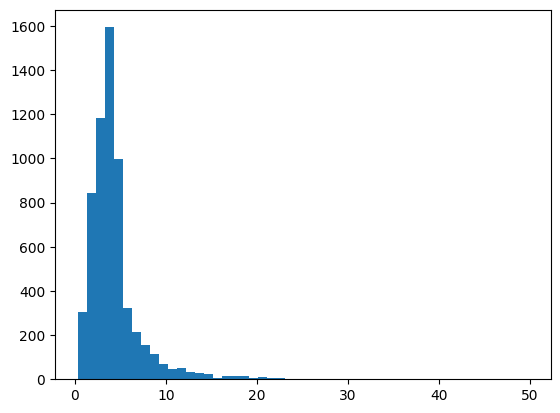

In [7]:
#plt.rcParams["figure.figsize"] = [5, 3]
nbins = int(np.ceil(sorted(sensor_durations[t])[:-discard][-1]))
x = plt.hist(sorted(sensor_durations[t])[:-discard],bins=nbins)
plt.show()

For quick and visual identification of a normal distribution, use a QQ plot if you have only one variable to look at and a Box Plot if you have many. Use a histogram if you need to present your results to a non-statistical public. As a statistical test to confirm your hypothesis, use the Shapiro Wilk test.

In [8]:
from scipy import stats
res = stats.shapiro(sensor_durations[t][:min(5000,len(sensor_durations[t]))])
res.pvalue

0.0

A p-value smaller than 0.05 means that the points do not follow a normal distribution

In [9]:
# Safety check with a normal distribution
res = stats.shapiro(np.random.normal(loc=np.mean(v),scale=np.std(v),size=min(5000,len(v))))
res.pvalue

0.9501494765281677

In [10]:
args = stats.weibull_min.fit(sensor_durations[t])

In [11]:
stats.kstest(sensor_durations[t], 'weibull_min', args=args, N=100000)

KstestResult(statistic=0.6323815478560787, pvalue=0.0, statistic_location=1.4964620000027935, statistic_sign=-1)

Let's see if they follow a Weibull distribution.<br>
The Weibull distribution is a two parameter continuous distribution of positive random variables that is commonly used to describe the failure time of physical entities 

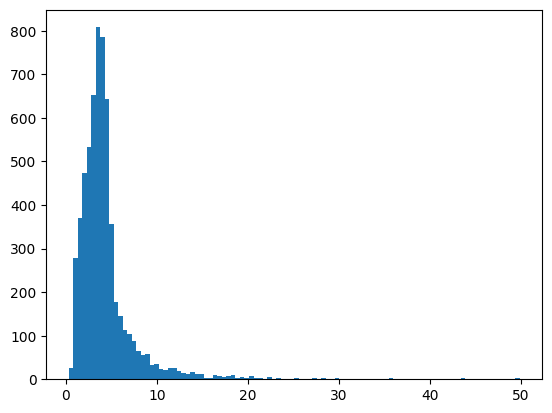

In [12]:
count, bins, ignored = plt.hist(sorted(sensor_durations[t])[:-3],bins=100)
x = np.arange(1,100.)/2.
#plt.plot(x, weib(x, 2, 4)*400)

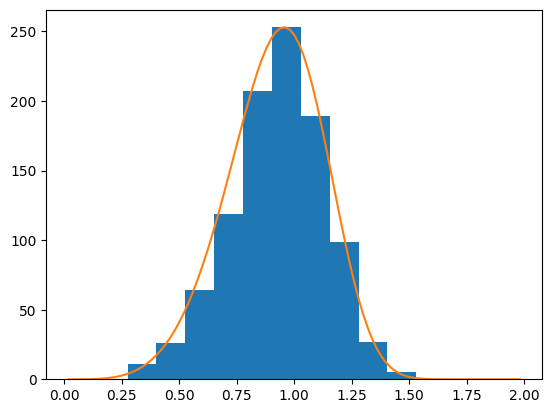

In [13]:
a = 5. # shape
s = np.random.weibull(a, 1000)
def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
count, bins, ignored = plt.hist(np.random.weibull(5.,1000))
x = np.arange(1,100.)/50.
scale = count.max()/weib(x, 1., 5.).max()
plt.plot(x, weib(x, 1., 5.)*scale)
plt.show()